In [1]:
# import libraries 

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from diffusers import AutoencoderKL

from models.vae import encode_img,decode_img

from utils.preprocess import scale_latents, preprocess_simulation_output_data, preprocess_experimental_backgroundwhite_rawfiles, preprocess_simulation_input_data, preprocess_experimental_backgroundwhite
from utils.display import display_predicted_images
from utils.config import SEED_FOLDER, EXPERIMENTAL_FOLDER, SIMULATED_FOLDER
from utils.config import FILES_FIG1A,FILES_FIG1B

/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-09-30 03:18:29,035] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Number of images - Seeds: 5, Sims: 5, Exps: 5


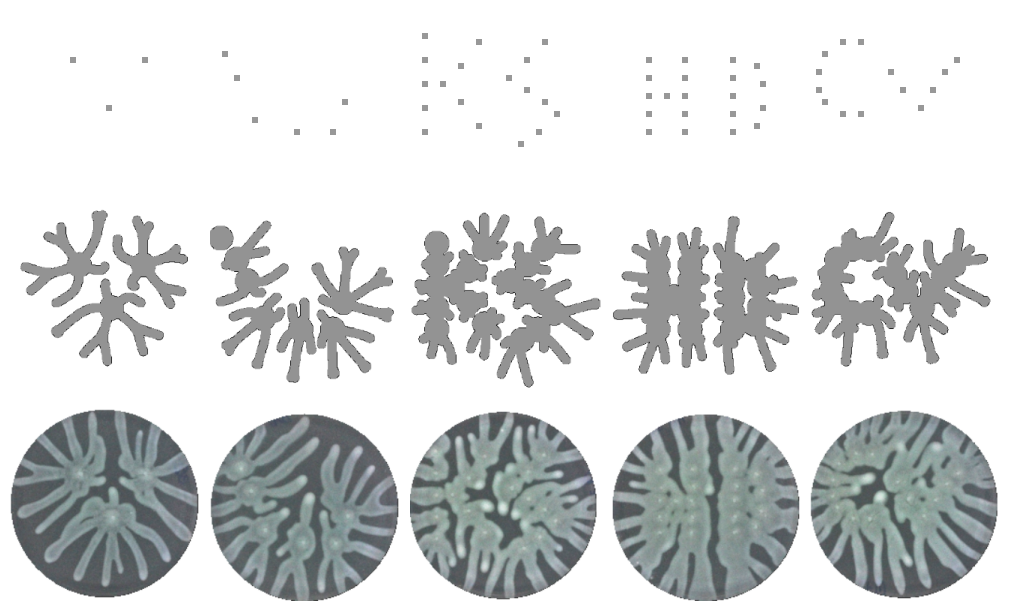

In [ ]:
"""
Display experimental patterns, seeds, and simulations - simplified version
"""

# Get file lists
seed_files = []
for f in FILES_FIG1A:
    base = os.path.splitext(f)[0]      # e.g. "Fixed_19_6"
    _, x, _ = base.split('_')           # x == "19"
    seed_name = f"Input_Fixed_{x}.png"
    seed_files.append(seed_name)

# Process images simply
seed_images = []
sim_images = []
exp_images = []

# Seed - now outputs RGB directly from preprocessing
seed_data = preprocess_simulation_input_data(SEED_FOLDER, 0, len(seed_files), img_filenames=seed_files)
seed_images = [data[0] for data in seed_data]  # Extract images 
# convert to RGB if not already, for display purposes in matplotlib
seed_images = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape)==2 else img for img in seed_images]

# Simulation - direct file processing  
sim_data = preprocess_simulation_output_data(SIMULATED_FOLDER, 0, len(FILES_FIG1A), img_filenames=FILES_FIG1A)
sim_images = [data[0] for data in sim_data]  # Extract images (grayscale)

# Experimental - use preprocessing function
exp_data = preprocess_experimental_backgroundwhite_rawfiles(EXPERIMENTAL_FOLDER, 0, len(FILES_FIG1A), img_filenames=FILES_FIG1A)
exp_images = exp_data  # This is already a list of images (RGB)

print(f"Number of images - Seeds: {len(seed_images)}, Sims: {len(sim_images)}, Exps: {len(exp_images)}")

# Plot - CLEANEST approach: seed images are RGB from preprocessing, no tricks needed
fig, axes = plt.subplots(3, len(FILES_FIG1A), figsize=(2*len(FILES_FIG1A), 6), layout='constrained')

for idx in range(len(FILES_FIG1A)):
    # Clean and simple - no cmap tricks, no RGB stacking, no vmin/vmax
    axes[0, idx].imshow(seed_images[idx],cmap='gray'); axes[0, idx].axis('off')  # RGB from preprocessing
    axes[1, idx].imshow(sim_images[idx], cmap='gray'); axes[1, idx].axis('off')  # Grayscale (continuous range)
    axes[2, idx].imshow(exp_images[idx]); axes[2, idx].axis('off')  # RGB

plt.show()

In [10]:
seed_images[0].shape

(32,)

Simulation images shape: (5, 256, 256)
Latents shape: torch.Size([5, 4, 32, 32])
Latents shape: torch.Size([5, 4, 32, 32])
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


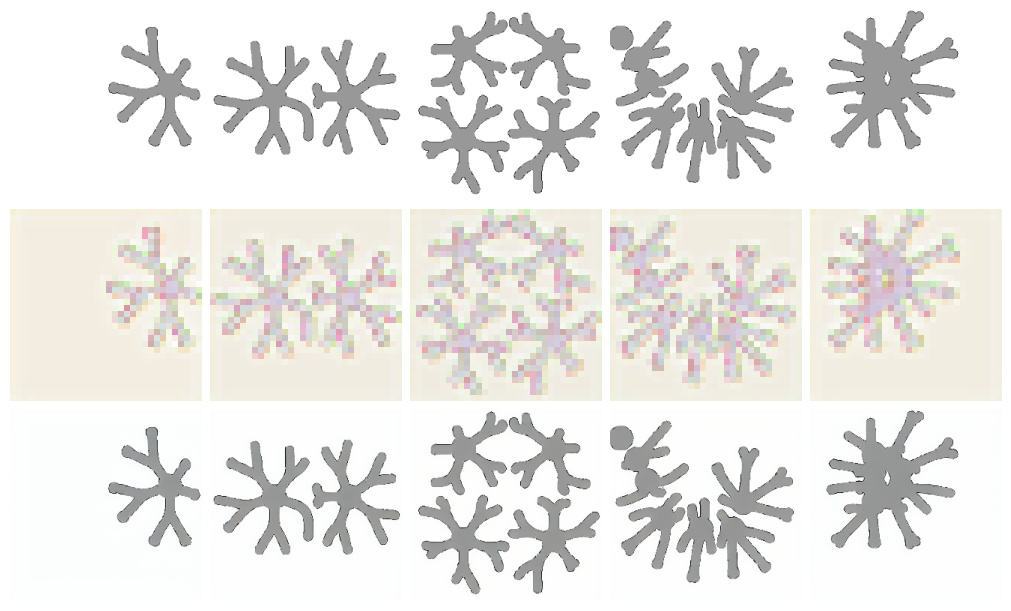

In [3]:
"""
Load and encode simulated images - simplified
"""

# Process simulation images
sim_data = preprocess_simulation_output_data(SIMULATED_FOLDER, 0, len(FILES_FIG1B), img_filenames=FILES_FIG1B)
sim_images = [data[0] for data in sim_data]  # Extract images
sim_images = np.array(sim_images)

print(f"Simulation images shape: {sim_images.shape}")

# Convert grayscale to RGB and normalize
sim_rgb = np.stack([sim_images, sim_images, sim_images], axis=-1)  # Make RGB
sim_rgb = np.transpose(sim_rgb, (0, 3, 1, 2)) / 255.0  # Normalize and reorder

# Convert to tensor and encode
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.Tensor(sim_rgb)

# Simple encoding (one batch at a time)
encoded_latents = []
for i in range(X.shape[0]):
    latent = encode_img(X[i:i+1].to(device))
    encoded_latents.append(latent.cpu())

# Combine results
latents = torch.cat(encoded_latents, dim=0)
latents_scaled = scale_latents(latents)
reconstructed = decode_img(latents)

print(f"Latents shape: {latents.shape}")
display_predicted_images(X, latents_scaled, reconstructed, 5)

Experimental images shape: (5, 256, 256, 3)
Latents shape: torch.Size([5, 4, 32, 32])
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


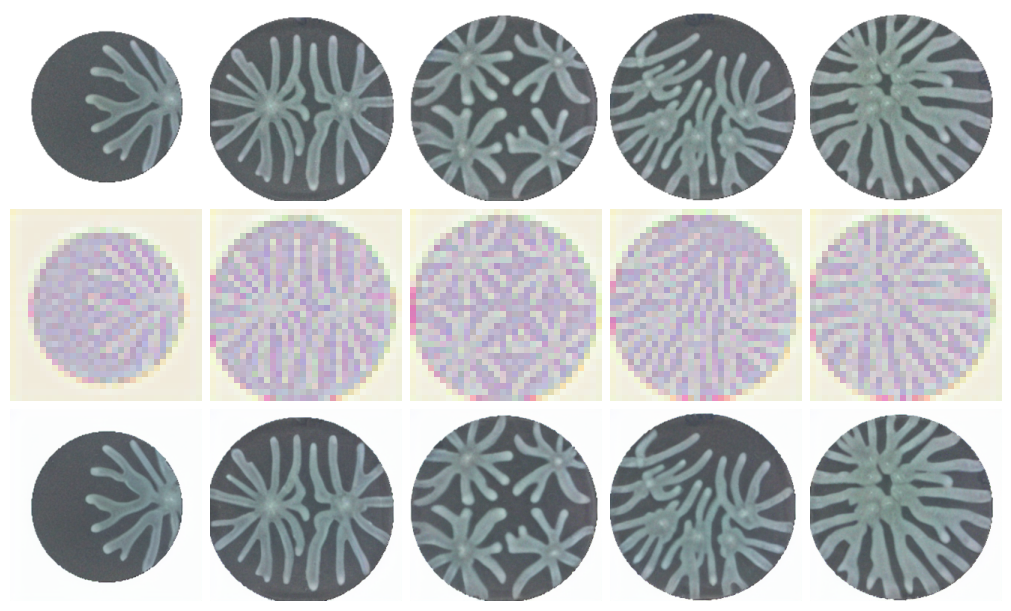

In [5]:
"""
Load and encode experimental images - simplified
"""

# Process experimental images - similar to simulation pattern
exp_data = preprocess_experimental_backgroundwhite_rawfiles(EXPERIMENTAL_FOLDER, 0, len(FILES_FIG1B), img_filenames=FILES_FIG1B)
exp_images = exp_data  # This is already a list of images
exp_images = np.array(exp_images)

print(f"Experimental images shape: {exp_images.shape}")

# Normalize and prepare for VAE
exp_images = np.transpose(exp_images, (0, 3, 1, 2)) / 255.0  # Normalize and reorder
X = torch.Tensor(exp_images)

# Simple encoding (one batch at a time)  
encoded_latents = []
for i in range(X.shape[0]):
    latent = encode_img(X[i:i+1].to(device))
    encoded_latents.append(latent.cpu())

# Combine results
latents = torch.cat(encoded_latents, dim=0)
latents_scaled = scale_latents(latents)
reconstructed = decode_img(latents)

print(f"Latents shape: {latents.shape}")
display_predicted_images(X[0:5], latents_scaled[0:5], reconstructed[0:5], 5)